In [ ]:
%pip install gensim
%pip install tqdm
%pip install nltk
%pip install transformers
%pip install ray[tune]
%pip install sklearn

In [2]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron, LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score

import gensim.downloader as api
from tqdm import tqdm
from nltk import word_tokenize
import torch
import multiprocessing

from transformers import AutoTokenizer, DataCollatorWithPadding, AutoModelForSequenceClassification, TrainingArguments, Trainer
import sys

sys.path.insert(0, '/home/jupyter/src/natalies-little-helper/util')
import helpers as helper

In [3]:
# Number of CPU cores available
cpu = multiprocessing.cpu_count()

# Set up cuda if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Number of GPUs being used
gpu = torch.cuda.device_count() if torch.cuda.is_available() else 0

# CPU and GPU Resources
proc_resources = {'cpu': cpu, 'gpu': gpu}

In [4]:
data_path = "/home/jupyter/src/natalies-little-helper/data/"

intent = pd.read_csv(data_path + "intent_Tweets.csv", index_col=0)

# yLabels = intent.negativereason.astype('category').cat.categories
print("Number of Negative Reasons: ", intent.negativereason.count())
intent.negativereason.value_counts()

Number of Negative Reasons:  9178


Customer Service Issue         2910
Late Flight                    1665
Can't Tell                     1190
Cancelled Flight                847
Lost Luggage                    724
Bad Flight                      580
Flight Booking Problems         529
Flight Attendant Complaints     481
longlines                       178
Damaged Luggage                  74
Name: negativereason, dtype: int64

In [5]:
intent = intent[intent['negativereason'].notna()]
intent.reset_index(drop=True, inplace=True)
num_labels = len(intent.negativereason.unique())

rmap = {reason: i for i, reason in enumerate(intent.negativereason.unique())}
imap = {i: reason for reason, i in rmap.items()}

yLabels = [imap[i] for i in range(len(imap))]

intent.negativereason = intent.negativereason.apply(lambda x: rmap[x])

## Select Samples

In [6]:
intent.intentGroup.value_counts()

Customer Service    4098
Flights             3092
Can't Tell          1190
Luggage              798
Name: intentGroup, dtype: int64

In [7]:
N_SAMPLES = 798
intent_groups_df = intent.groupby('intentGroup').apply(lambda x: x.sample(n=N_SAMPLES)).reset_index(drop=True)
intent_group_labels = intent.intentGroup.astype('category').cat.categories
intent_group_map = {group: i for i, group in enumerate(intent_group_labels)}
intent_groups_df.intentGroup = intent_groups_df.intentGroup.apply(lambda x: intent_group_map[x])

In [8]:
intent_groups_df.intentGroup.value_counts()

0    798
1    798
2    798
3    798
Name: intentGroup, dtype: int64

## Split Train and Test Data

In [9]:
vectorizer = TfidfVectorizer(min_df=0.0001, max_df=0.9999, ngram_range=(1,3), max_features=10000)
X = vectorizer.fit_transform(intent.text)

scaler = StandardScaler(with_mean=False)
scaler.fit(X)

xTrain, xTest, yTrain, yTest = train_test_split(X, intent.negativereason, train_size=0.8, stratify=intent.negativereason)

In [10]:
XGroup = vectorizer.fit_transform(intent_groups_df.text)
xGroupTrain, xGroupTest, yGroupTrain, yGroupTest = train_test_split(XGroup, intent_groups_df.intentGroup, train_size=0.8, stratify=intent_groups_df.intentGroup)

# Base Classifiers

## Perceptron

### Intent Reasons

In [11]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
clf.fit(scaler.transform(xTrain), yTrain)
# clf.fit(xTrain, yTrain)

# yPred = clf.predict(xTest)

# precisions = precision_score(yTest, yPred, average=None)
# recalls = recall_score(yTest, yPred, average=None)
# f1s = f1_score(yTest, yPred, average=None)

# helper.evaluate_score(yTest, yPred)

OneVsRestClassifier(estimator=Perceptron(n_jobs=-1), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.46      0.32      0.38       116
           1       0.38      0.39      0.38       238
           2       0.63      0.67      0.65       333
           3       0.63      0.69      0.66       582
           4       0.44      0.25      0.32       106
           5       0.61      0.60      0.60       145
           6       0.40      0.18      0.24        96
           7       0.74      0.72      0.73       169
           8       0.03      0.13      0.04        15
           9       0.17      0.11      0.13        36

    accuracy                           0.55      1836
   macro avg       0.45      0.41      0.41      1836
weighted avg       0.56      0.55      0.55      1836



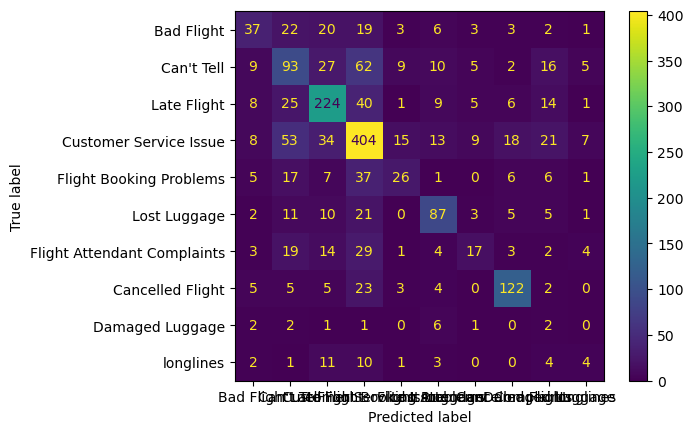

array([3, 5, 2, ..., 3, 2, 3])

In [12]:
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [13]:
clf = OneVsRestClassifier(Perceptron(n_jobs=-1), n_jobs=-1)
clf.fit(scaler.transform(xGroupTrain), yGroupTrain)

OneVsRestClassifier(estimator=Perceptron(n_jobs=-1), n_jobs=-1)

              precision    recall  f1-score   support

           0       0.52      0.55      0.53       159
           1       0.61      0.56      0.58       160
           2       0.68      0.64      0.66       160
           3       0.77      0.84      0.80       160

    accuracy                           0.65       639
   macro avg       0.65      0.65      0.64       639
weighted avg       0.65      0.65      0.65       639



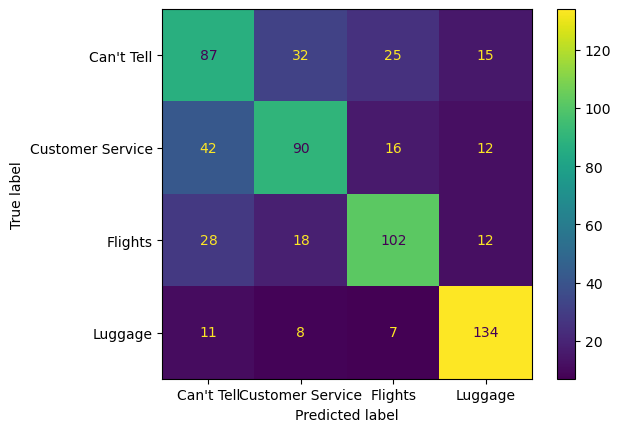

In [14]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

## Logistic Regression

### Intent Reasons

In [15]:
clf = LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)
clf.fit(xTrain, yTrain)

yPred = clf.predict(xTest)

helper.evaluate_score(yTest, yPred)

Accuracy:	 0.6127450980392157
Precision:	 [0.60273973 0.41312741 0.66666667 0.59947644 0.5625     0.75806452
 0.575      0.79605263 0.         0.75      ]
Recall: 	 [0.37931034 0.44957983 0.74474474 0.78694158 0.25471698 0.64827586
 0.23958333 0.71597633 0.         0.08333333]
F1 scores:	 [0.46560847 0.4305835  0.7035461  0.68053492 0.35064935 0.69888476
 0.33823529 0.75389408 0.         0.15      ]
Average
	Precision: 0.6129709532010726
	Recall: 0.6127450980392157
	F1: 0.5940236589357966


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


1836
1836
{0, 1, 2, 3, 4, 5, 6, 7, 9}
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
              precision    recall  f1-score   support

           0       0.60      0.38      0.47       116
           1       0.41      0.45      0.43       238
           2       0.67      0.74      0.70       333
           3       0.60      0.79      0.68       582
           4       0.56      0.25      0.35       106
           5       0.76      0.65      0.70       145
           6       0.57      0.24      0.34        96
           7       0.80      0.72      0.75       169
           8       0.00      0.00      0.00        15
           9       0.75      0.08      0.15        36

    accuracy                           0.61      1836
   macro avg       0.57      0.43      0.46      1836
weighted avg       0.61      0.61      0.59      1836



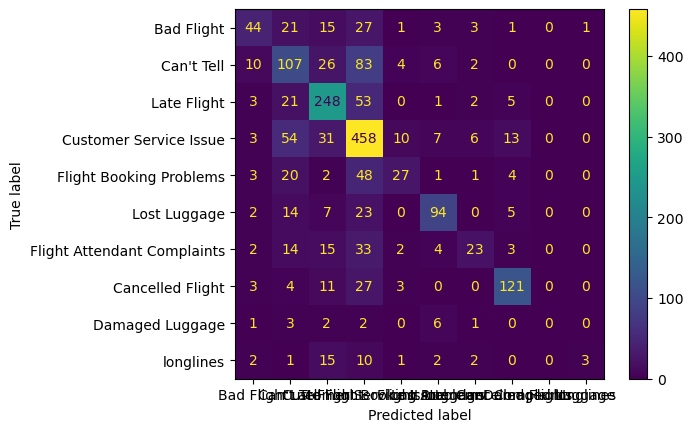

array([6, 3, 1, ..., 3, 3, 3])

In [16]:
print(len(yPred))
print(len(yTest))
ySet = {y for y in yPred}
yTSet = {y for y in yTest}
print(ySet)
print(yTSet)
# helper.evaluate_score([0,1,2,3,4], [1,2,0,3,3])
# helper.evaluate_score(yTest, yPred)
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [17]:
clf = LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)
clf.fit(xGroupTrain, yGroupTrain)

LogisticRegressionCV(cv=5, max_iter=5000, n_jobs=-1)

              precision    recall  f1-score   support

           0       0.58      0.63      0.61       159
           1       0.62      0.61      0.61       160
           2       0.67      0.66      0.67       160
           3       0.88      0.84      0.86       160

    accuracy                           0.68       639
   macro avg       0.69      0.68      0.69       639
weighted avg       0.69      0.68      0.69       639



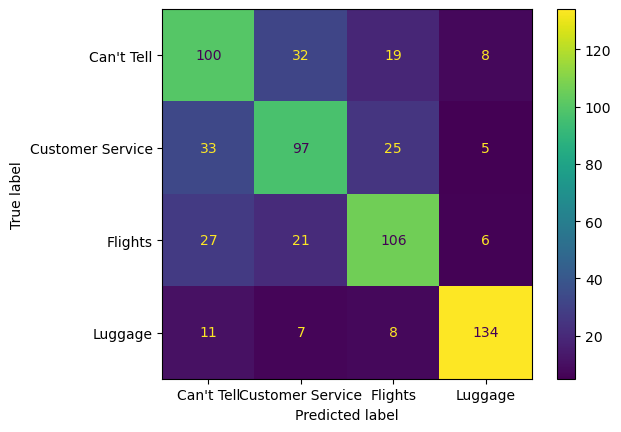

In [18]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

## SVC

### Intent Reasons

In [19]:
clf = LinearSVC()
clf.fit(xTrain, yTrain)

# yPred = clf.predict(xTest)

# helper.evaluate_score(yTest, yPred)

LinearSVC()

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.49      0.41      0.45       116
           1       0.42      0.45      0.43       238
           2       0.65      0.71      0.68       333
           3       0.64      0.73      0.68       582
           4       0.47      0.34      0.40       106
           5       0.71      0.72      0.71       145
           6       0.42      0.28      0.34        96
           7       0.77      0.73      0.75       169
           8       0.00      0.00      0.00        15
           9       0.57      0.11      0.19        36

    accuracy                           0.61      1836
   macro avg       0.51      0.45      0.46      1836
weighted avg       0.59      0.61      0.59      1836



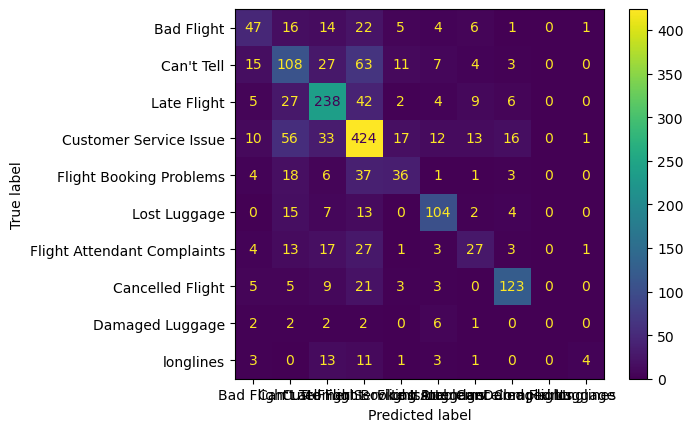

array([6, 3, 5, ..., 3, 3, 0])

In [20]:
helper.evaluate_model(clf, xTest, yTest, yLabels)

### Intent Groups

In [21]:
clf = LinearSVC()
clf.fit(xGroupTrain, yGroupTrain)

LinearSVC()

              precision    recall  f1-score   support

           0       0.55      0.57      0.56       159
           1       0.61      0.57      0.59       160
           2       0.65      0.66      0.66       160
           3       0.84      0.85      0.84       160

    accuracy                           0.66       639
   macro avg       0.66      0.66      0.66       639
weighted avg       0.66      0.66      0.66       639



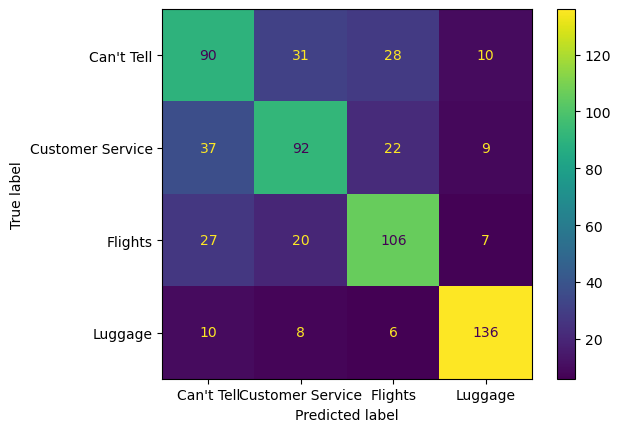

In [22]:
pred = helper.evaluate_model(clf, xGroupTest, yGroupTest, intent_group_labels)

# Distilbert Tokenizer

In [23]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased", Truncation=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
# model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

In [24]:
data_og = pd.concat([intent.text, intent.negativereason], axis=1)

data = []
for t in data_og.iterrows():
    temp = {}
    temp["text"] = t[1].text
    temp["label"] = t[1].negativereason
    temp.update(tokenizer(t[1].text))
    data.append(temp)

train, test = train_test_split(data, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)

In [25]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=num_labels)

training_args = TrainingArguments(
    output_dir="./intent_results",
    learning_rate=2e-5,
    evaluation_strategy = "steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
)

trainer_tuned = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=train,
    eval_dataset=val,
    tokenizer=tokenizer,
    data_collator=data_collator,
)

loading configuration file config.json from cache at /home/jupyter/.cache/huggingface/hub/models--distilbert-base-uncased/snapshots/043235d6088ecd3dd5fb5ca3592b6913fd516027/config.json
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4,
    "LABEL_5": 5,
    "LABEL_6": 6,
    "LABEL_7": 7,
    "LABEL_8": 8,
    "LABEL_9": 9
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dro

In [ ]:
best_run = trainer_tuned.hyperparameter_search(n_trials=10, direction="maximize", resources_per_trial=proc_resources)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


2022-11-14 01:21:20,827	INFO worker.py:1528 -- Started a local Ray instance.


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


/opt/conda/lib/python3.7/site-packages/ray/tune/trainable/function_trainable.py:611: DeprecationWarning: `checkpoint_dir` in `func(config, checkpoint_dir)` is being deprecated. To save and load checkpoint in trainable functions, please use the `ray.air.session` API:

from ray.air import session

def train(config):
    # ...
    session.report({"metric": metric}, checkpoint=checkpoint)

For more information please see https://docs.ray.io/en/master/tune/api_docs/trainable.html

  DeprecationWarning,


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


(raylet) [2022-11-14 01:21:24,347 E 32190 32212] (raylet) agent_manager.cc:134: The raylet exited immediately because the Ray agent failed. The raylet fate shares with the agent. This can happen because the Ray agent was unexpectedly killed or failed. See `dashboard_agent.log` for the root cause.
2022-11-14 01:21:53,631	WARNING worker.py:1839 -- The node with node id: a6bb912bcd74d56e4d68e156c7cb6fdca2633e9bbb5986b3639cf68b and address: 10.138.0.2 and node name: 10.138.0.2 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a 	(1) raylet crashes unexpectedly (OOM, preempted node, etc.) 
	(2) raylet has lagging heartbeats due to slow network or busy workload.
2022-11-14 01:21:53,639	WARNING resource_updater.py:51 -- Cluster resources not detected or are 0. Attempt #2...
[2022-11-14 01:21:53,656 E 31860 32234] core_worker.cc:528: :info_message: Attempting to recover 1 lost objects by resubmitting their tasks. To disable object reconstruc

== Status ==
Current time: 2022-11-14 01:21:24 (running for 00:00:00.23)
Memory usage on this node: 3.4/14.7 GiB 
Using FIFO scheduling algorithm.
Resources requested: 4.0/4 CPUs, 0/0 GPUs, 0.0/6.76 GiB heap, 0.0/3.38 GiB objects
Result logdir: /home/jupyter/ray_results/_objective_2022-11-14_01-21-24
Number of trials: 10/10 (9 PENDING, 1 RUNNING)
+------------------------+----------+-------+-----------------+--------------------+------------------------+----------+
| Trial name             | status   | loc   |   learning_rate |   num_train_epochs |   per_device_train_bat |     seed |
|                        |          |       |                 |                    |                ch_size |          |
|------------------------+----------+-------+-----------------+--------------------+------------------------+----------|
| _objective_a7562_00000 | RUNNING  |       |     5.61152e-06 |                  5 |                     64 |  8.15396 |
| _objective_a7562_00001 | PENDING  |       | 

2022-11-14 01:21:54,141	WARNING resource_updater.py:51 -- Cluster resources not detected or are 0. Attempt #3...
2022-11-14 01:21:54,643	WARNING resource_updater.py:51 -- Cluster resources not detected or are 0. Attempt #4...
2022-11-14 01:21:55,146	WARNING resource_updater.py:51 -- Cluster resources not detected or are 0. Attempt #5...
2022-11-14 01:21:55,648	WARNING resource_updater.py:64 -- Cluster resources cannot be detected or are 0. You can resume this experiment by passing in `resume=True` to `run`.
2022-11-14 01:33:07,727	WARNING tune.py:706 -- Stop signal received (e.g. via SIGINT/Ctrl+C), ending Ray Tune run. This will try to checkpoint the experiment state one last time. Press CTRL+C (or send SIGINT/SIGKILL/SIGTERM) to skip. 


In [ ]:
for n, v in best_run.hyperparameters.items():
    setattr(trainer_tuned.args, n, v)

trainer_tuned.train()

In [ ]:
preds = trainer_tuned.predict(test_dict)

In [ ]:
yTrue = [t["label"] for t in test_dict]
yPred = [p.argmax() for p in preds[0]]
helper.evaluate_score(yTrue, yPred)